# ADC tests - `20180103a` test of acquisition with a AD08200 ADC pHAT

## Testing Hannes file with AD08200
 

The acquisition using cat took only milliseconds. So we added a delay in scope.c. This changes the sample frequency.
Actually, we don't if that was a good idea. The head did a minimal movement. I guess we have to collect even more data.
I added some comments at parts of the code that I cannot follow. Mostly, it is about hardcoded numbers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.signal import decimate, convolve
import math
from scipy.interpolate import griddata

def GetSeries(Volts):
    
    Map = np.zeros((len(Volts)-1,34), dtype=np.int)#why 34 here?
    for i in range(len(Volts)-1):
        val = Volts[i]
        for k in range(34):
            Map[i][k] = (val & 2**k)/2**k

    return Map

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Opening file

In [2]:
filename = "rawdata/hannes25.dat"
Bytes = np.fromfile(filename, dtype = '<i4')


In [3]:
#n = len(Bytes)
n = len(Bytes)-1#did you mean this?
print n
#Map = GetSeries(Bytes)
Map = GetSeries(Bytes[:-1])#did you mean this?
#Duration = Bytes[n-1]
Duration = Bytes[-1]#did you mean this?
Fech = n*1.0/(Duration*1e-9)/1e6
print Fech
#guess the frequency is correct because we added a delay to the scope.c
#don't know if this was a good idea or not :)

2000000
12.1469825705


In [4]:
print "It took "+str(Duration)+ "ns to record "+ str(n)+" samples."
print "Sampling freq is "+str(Fech)+" Msps."

It took 164649944ns to record 2000000 samples.
Sampling freq is 12.1469825705 Msps.


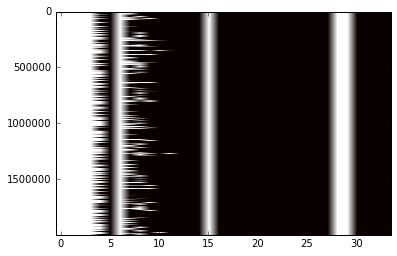

In [5]:
im = plt.imshow(Map, cmap='hot', aspect="auto")
#plt.colorbar(im, orientation='horizontal')
plt.show()

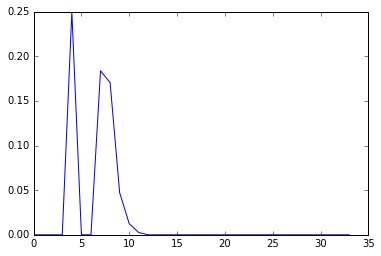

In [6]:
plt.plot(np.var(Map,0))
plt.show()

In [7]:
for m in range(32):
    if (np.var(Map,0)[m] > 0.0003) :
        print str(m)+" - "+str(np.var(Map,0)[m])


4 - 0.249830759244
7 - 0.183682481957
8 - 0.170455192101
9 - 0.0470952702707
10 - 0.0124022525223
11 - 0.00251265589207


# Bits on the AD08200

Clock: close to 0.25

* D0: 26 - GPIO7
* D1: 24 - GPIO8
* D2: 21 - GPIO9
* D3: 19 - GPI10
* D4: 23 - GPI11
* D5: 16 - GPI23
* D6: 18 - GPI24
* D7: 22 - GPI25

In [8]:
ADC2_GPIO = [7, 8,9,10,11,23,24,25]
ADC2len = len( ADC2_GPIO)

In [9]:
def GetV2(Volts):
    Signal = []
    Map = np.zeros((len(Volts),ADC2len), dtype=np.int)
    for i in range(len(Volts)):
        val = Volts[i]
        SignalZero = 0
        for k in range(ADC2len):
            Map[i][k] = (val & 2**k)/2**k
        for k in range(ADC2len):
            SignalZero += 2**k*((val & 2**ADC2_GPIO[k])/2**ADC2_GPIO[k])
        Signal.append(SignalZero)

            
    return Signal,Map

2000000
2000000


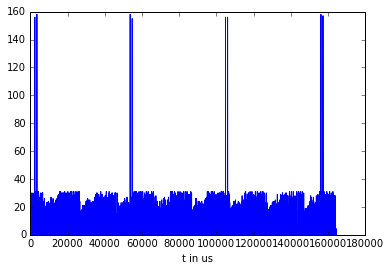

In [10]:
t = range(n)
for k in range(n):
    t[k] = 1.0*t[k]/Fech
#M = GetV2(Bytes)[0]
M = GetV2(Bytes[:-1])[0]#did you mean this?
print len(M)
print len(t)
plt.plot(t,M[0:n])
plt.xlabel('t in us')
plt.show()

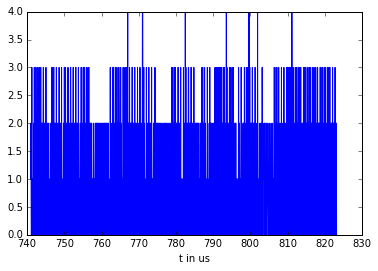

In [11]:
plt.plot(t[9000:10000],M[9000:10000])
plt.xlabel('t in us')
plt.show()

In [12]:
#get the normalized signal
rawSig = M - np.average(M)
print len(rawSig)

2000000


In [13]:
#perform FFT and delete unwanted frequencies
FFT = np.fft.fft(rawSig)
FFTCleaned = np.fft.fft(rawSig)
FStart = 0.068*len(FFTCleaned)
FStop = 0.196*len(FFTCleaned)
for k in range(len(FFTCleaned)/2):
    if (k < FStart or k > FStop): # in (k < 550000 or k > 790000) # 0.068 0.196 #where are these numbers coming from?
        FFTCleaned[k] = 0
        FFTCleaned[-k] = 0

1000000
1000000


/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


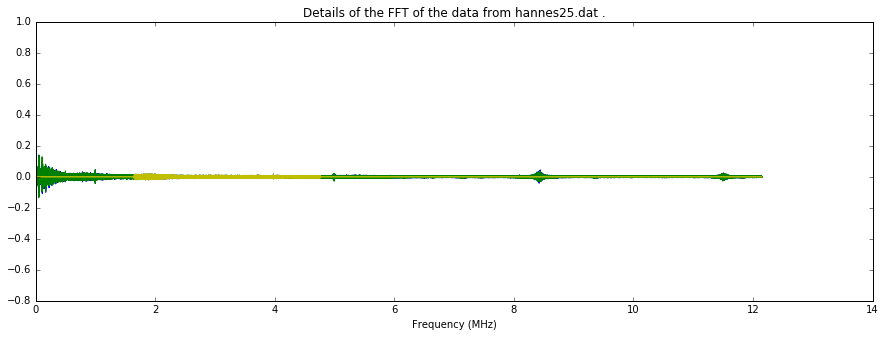

In [14]:
#plot the spectrum and the cleaned spectrum
Scale = max(FFT)
ff = [ Fech*2.0*x/(len(rawSig)) for x in range(len(rawSig)/2)]
plt.figure(figsize=(15,5))
print len(ff)
print len(np.real(FFT)[0:len(FFT)/2]/Scale)
plt.plot(ff,np.real(FFT)[0:len(FFT)/2]/Scale,"b")
plt.plot(ff,np.imag(FFT)[0:len(FFT)/2]/Scale,"g")
plt.plot(ff,np.imag(FFTCleaned)[0:len(FFT)/2]/Scale,"y")
plt.plot(ff,np.real(FFTCleaned)[0:len(FFT)/2]/Scale,"y")
plt.title("Details of the FFT of the data from "+filename.split("/")[-1]+" .")  
plt.xlabel("Frequency (MHz)")
#plt.savefig('Imgs/fft_'+RawData.split("/")[-1]+".png", bbox_inches='tight')
plt.show()

In [15]:
#transfer the cleaned spectrum back to the time domain
F = np.real(np.fft.ifft(FFTCleaned))

In [16]:
#calculate the envelope using a hilbert transform
FH = np.asarray(np.abs(signal.hilbert(F)))

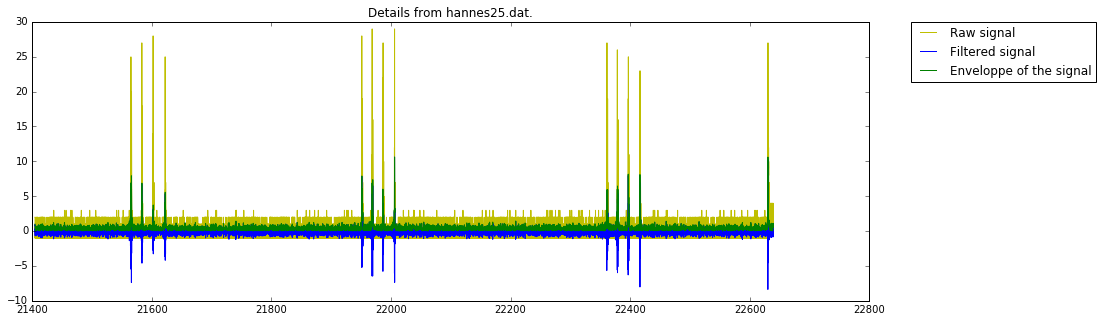

In [17]:
#print the raw signal, filtered signal and envelope on the index line
IndexEmpty = 20 #where does this number come from?
IndexLine = 104 #where does this number come from?
tt = IndexLine*2500 #where does this number come from?
plt.figure(figsize=(15,5))
T = [ (( x * Duration ) / ( 1000.0*len(rawSig) )) for x in 2*range(len(rawSig))]
TT = np.divide(T,2.0)
plt.plot(TT[2*tt:2*tt+2*15000],rawSig[2*tt:2*tt+2*15000],"y", label='Raw signal') #where does this number (15000) come from?
plt.plot(TT[2*tt:2*tt+2*15000],np.real(np.fft.ifft(FFTCleaned))[2*tt:2*tt+2*15000],"b", label='Filtered signal')
plt.plot(TT[2*tt:2*tt+2*15000],FH[2*tt:2*tt+2*15000],"g", label='Enveloppe of the signal')
plt.title("Details from "+filename.split("/")[-1]+".")  
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig('Imgs/datas_'+RawData.split("/")[-1]+'.png', bbox_inches='tight')
plt.show()


In [18]:
#the reshape the signal
#tableData = np.asarray(FH).reshape((1000,2*2500)) where are these dimensions coming from??
#tableDataRaw = np.asarray(rawSig).reshape((1000,2*2500))

#randomly trying out dimensions...
ydim = 2500
xdim = n/ydim
tableData = np.asarray(FH).reshape((xdim,ydim))

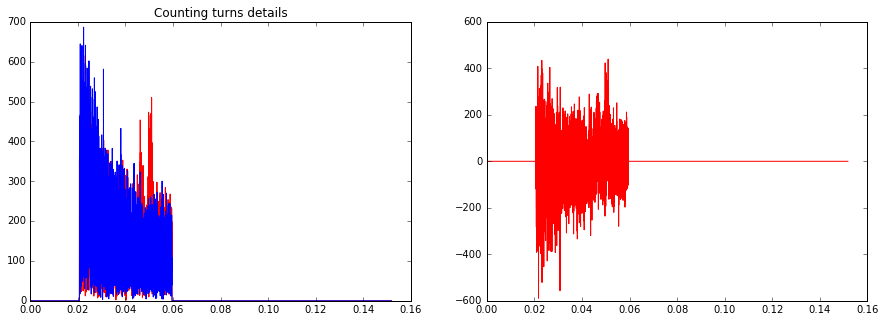

In [19]:
#not sure what this plot is used for...
EmptyLine = rawSig[5000*IndexEmpty:5000*IndexEmpty+25000]
FullLine = rawSig[5000*IndexLine:5000*IndexLine+25000]
FFul = np.fft.fft(FullLine)
FFem = np.fft.fft(EmptyLine)
for i in range(len(FullLine)/2):
    if (i < 1700 or i > 4900):
        FFul[i] = 0
        FFem[i] = 0
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(ff[0:len(FullLine)/2],np.abs(FFul)[0:len(FullLine)/2],"r")
ax1.plot(ff[0:len(FullLine)/2],np.abs(FFem)[0:len(FullLine)/2],"b")
ax1.set_title('Counting turns')

ax1.set_title('Counting turns details')
diff = np.abs(FFul) - np.abs(FFem)
ax2.plot(ff[0:len(FullLine)/2],diff[0:len(FullLine)/2],"r")
plt.show()

3000
2500


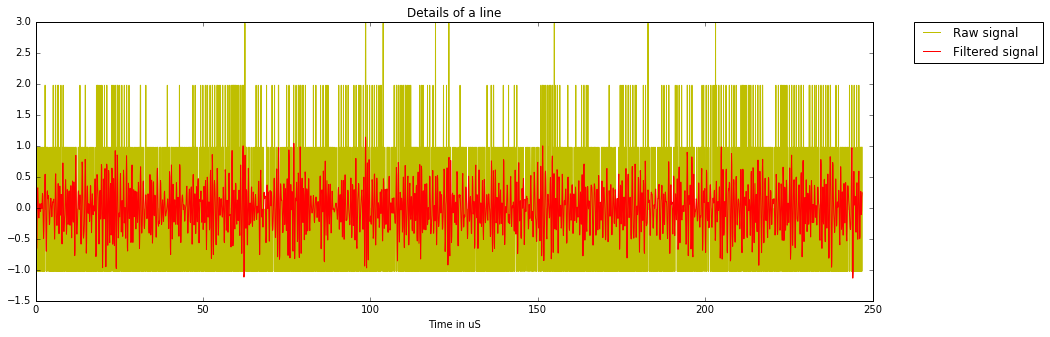

In [20]:
ExLine = tableData[IndexLine]
ExLineRaw = tableData[IndexLine]
plt.figure(figsize=(15,5))
plt.plot(T[0:3000],rawSig[5000*IndexLine:5000*IndexLine+3000],"y", label='Raw signal')
plt.plot(T[0:3000],F[5000*IndexLine:5000*IndexLine+3000],"r", label='Filtered signal')
#plt.plot(T[0:3000],ExLine[0:3000],"b", label='Enveloppe of the signal')
print len(T[0:3000])
print len(ExLine[0:3000])
#the dimensions are not matching. guess theres something wrong with the dimensions of tableData
plt.title("Details of a line")
plt.xlabel("Time in uS")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig('Imgs/ProcessingLine_'+RawData.split("/")[-1]+".png", bbox_inches='tight')
plt.show()

In [21]:
#add an offset to the image, will do that later
#get average value
Val = np.average(tableData)
#tableData = np.asarray(FH).reshape((1000,2*2500))
#Offset = 400
#MinTable = 10*np.min(tableData)
#Zeroes = np.zeros((2500,Offset))+Val
#BigTable = []
#BigTable = np.append(Zeroes, tableData, axis=1)

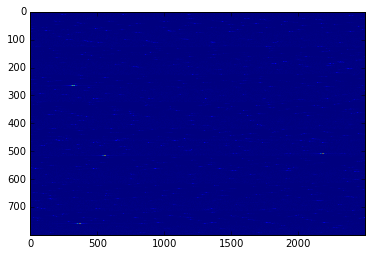

In [22]:
#plot the reshaped data
#there are some dots, so guess the file contains data
plt.imshow((abs(tableData)), aspect='auto')
#plt.axhline(IndexLine, color='r', linestyle='--')
#plt.title("Mapping the data from "+RawData.split("/")[-1]+" .")  
#plt.savefig('Imgs/map_'+RawData.split("/")[-1]+".png", bbox_inches='tight')
plt.show()

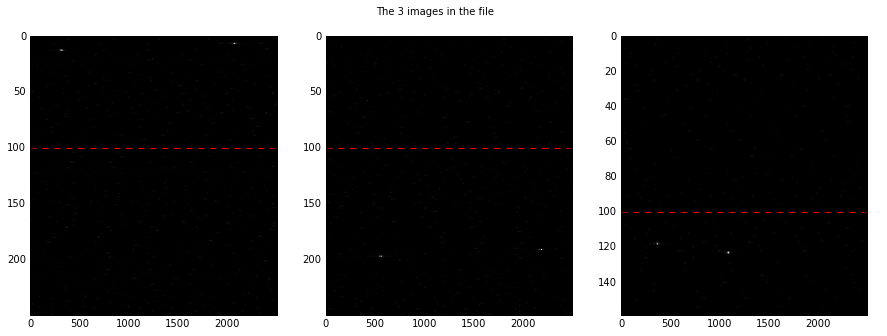

In [23]:
#this is plotting the images of the three runs. but we only have one...
ListOfPoints= [104, 418, 741]#where are these numbers coming from?

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

TmpImg = (abs(tableData[ListOfPoints[0]-100:ListOfPoints[0]+150]))**(1.1)
ax1.imshow(TmpImg,cmap=plt.get_cmap('gray'), aspect='auto')
ax1.axhline(100, color='r', linestyle='--')
TmpImg = (abs(tableData[ListOfPoints[1]-100:ListOfPoints[1]+150]))**(1.1)
ax2.imshow(TmpImg,cmap=plt.get_cmap('gray'), aspect='auto')
ax2.axhline(100, color='r', linestyle='--')
TmpImg = (abs(tableData[ListOfPoints[2]-100:ListOfPoints[2]+150]))**(1.1)
ax3.imshow(TmpImg,cmap=plt.get_cmap('gray'), aspect='auto')
ax3.axhline(100, color='r', linestyle='--')
plt.suptitle('The 3 images in the file')
#plt.savefig('Imgs/images_'+RawData.split("/")[-1]+".png", bbox_inches='tight')
#plt.savefig('Imgs/mapCleanImage_'+RawData.split("/")[-1]+str(Start)+"-"+str(Stop)+".jpg", bbox_inches='tight')
plt.show()

In [24]:
#this makes one image out of the 3 runs, guess this is for noise reduction.
#we cannot do this because we only have 1 run
DecImg = []
for i in range(150):
    tmp = decimate(tableData[ListOfPoints[0]-70+i], 5, ftype='fir')
    #tmp += decimate(tableData[ListOfPoints[1]-70+i], 5, ftype='fir')
    #tmp += decimate(tableData[ListOfPoints[2]-70+i], 5, ftype='fir')
    DecImg.append(tmp)

/usr/local/lib/python2.7/dist-packages/scipy/signal/filter_design.py:1092: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:3073: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


In [25]:
#downsample the image, don't know if this is really necessary
SmallImg = []
for i in range(len(DecImg)/2):
    SmallImg.append((DecImg[2*i]+DecImg[2*i+1])/2)

In [26]:
#function to rotate and shring the image
def CreateSC(RawImgData):
    LenLinesC = np.shape(RawImgData)[1]
    NbLinesC = np.shape(RawImgData)[0]
    SC = np.zeros((LenLinesC,LenLinesC))+Val
    SC += 1
    maxAngle = 60.0
    step = maxAngle/(NbLinesC+1)
    CosAngle = math.cos(math.radians(30))
    Limit = LenLinesC*CosAngle

    points = []
    values = []

    for i in range(LenLinesC):
        for j in range(LenLinesC):
            if (  (j > LenLinesC/2 + i/(2*CosAngle)) or  (j < LenLinesC/2 - i/(2*CosAngle)) ):
                SC[i][j] = 0
                points.append([i,j])
                values.append(0)
            if (  (i > Limit) ):
                if ( (i**2 + (j-LenLinesC/2) ** 2) > LenLinesC**2):
                    SC[i][j] = 0 
                    points.append([i,j])
                    values.append(0)
    for i in range(NbLinesC):
        PointAngle = i*step-30
        COS = math.cos(math.radians(PointAngle))
        SIN = math.sin(math.radians(PointAngle))
        for j in range(LenLinesC):

            X = (int)( j*COS)
            Y = (int)(LenLinesC/2 - j*SIN)
            SC[X][Y] = RawImgData[i][j]
            points.append([X,Y])
            values.append(RawImgData[i][j])

    values = np.array(values,dtype=np.int)
    
    return SC,values,points,LenLinesC

In [27]:
#create the rotated shrinked image
SCH,valuesH,pointsH,LenLinesCH = CreateSC(SmallImg)
grid_xH, grid_yH = np.mgrid[0:LenLinesCH:1, 0:LenLinesCH:1]
grid_z1H = griddata(pointsH, valuesH, (grid_xH, grid_yH), method='linear')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


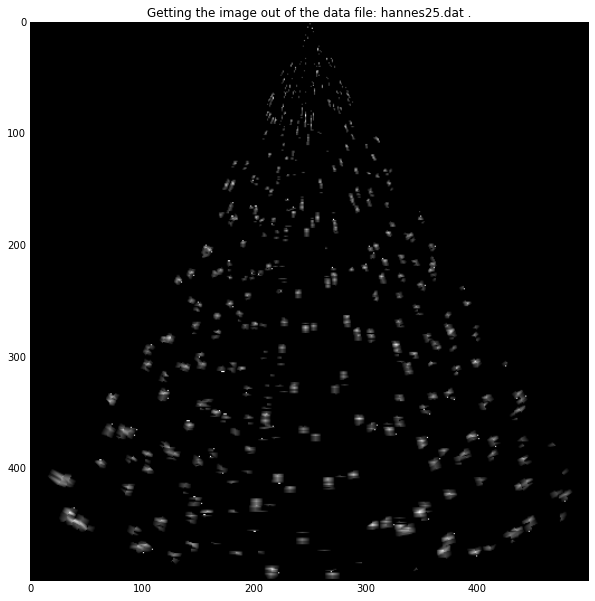

In [28]:
#plot it
plt.figure(figsize=(10,10))
plt.imshow((grid_z1H**0.7),cmap=plt.get_cmap('gray')) 
plt.title("Getting the image out of the data file: "+filename.split("/")[-1]+" .")  
#plt.savefig('Imgs/pic_'+RawData.split("/")[-1]+".png", bbox_inches='tight')
plt.show()